In [346]:
#importing packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#train test split
from sklearn.model_selection import train_test_split
import re
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 


#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import os
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth',500)
pd.set_option('display.max_columns',5000)
from IPython.display import Image
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
encoder = LabelEncoder()

In [347]:
train = pd.read_csv("C:/Users/mrinal.ghoshal/Desktop/Assingment/data/train_data.csv")

In [348]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,117578,8,725,45,0
1,123337,29,265,334,0
2,46642,13,281,408,0
3,10510,13,625,577,0
4,14347,13,480,414,0


In [349]:
test = pd.read_csv('C:/Users/mrinal.ghoshal/Desktop/Assingment/data/test_data.csv')
campaign = pd.read_csv('C:/Users/mrinal.ghoshal/Desktop/Assingment/data/campaign_data.csv')
coupons = pd.read_csv('C:/Users/mrinal.ghoshal/Desktop/Assingment/data/coupon_item_mapping.csv')
cust_demo = pd.read_csv('C:/Users/mrinal.ghoshal/Desktop/Assingment/data/customer_demographics.csv')
cust_tran = pd.read_csv('C:/Users/mrinal.ghoshal/Desktop/Assingment/data/customer_transaction_data.csv')
items = pd.read_csv('C:/Users/mrinal.ghoshal/Desktop/Assingment/data/item_data.csv')

In [350]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54858 entries, 0 to 54857
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 54858 non-null  int64
 1   campaign_id        54858 non-null  int64
 2   coupon_id          54858 non-null  int64
 3   customer_id        54858 non-null  int64
 4   redemption_status  54858 non-null  int64
dtypes: int64(5)
memory usage: 2.1 MB


In [351]:
len(train.campaign_id.unique())

18

In [352]:
train.campaign_id.dtypes

dtype('int64')

In [353]:
train.redemption_status.value_counts()

0    54340
1      518
Name: redemption_status, dtype: int64

In [354]:
518/(54340+518)*100

0.9442560793320938

only 0.94% of the coupons were redemed

In [355]:
print('Campaign Dataframe')
print(campaign.isnull().sum())
print('======================')
print('Items Dataframe')
print(items.isnull().sum())
print('======================')
print('Coupons Dataframe')
print(coupons.isnull().sum())
print('======================')
print('Customer Demographics Dataframe')
print(cust_demo.isnull().sum())
print('======================')
print('Customer Transaction Dataframe')
print(cust_tran.isnull().sum())
print('======================')

Campaign Dataframe
campaign_id      0
campaign_type    0
start_date       0
end_date         0
dtype: int64
Items Dataframe
item_id       0
brand         0
brand_type    0
category      0
dtype: int64
Coupons Dataframe
coupon_id    0
item_id      0
dtype: int64
Customer Demographics Dataframe
customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64
Customer Transaction Dataframe
date               0
customer_id        0
item_id            0
quantity           0
selling_price      0
other_discount     0
coupon_discount    0
dtype: int64


In [356]:
cust_demo.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [357]:
cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  431 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    object
 5   no_of_children  222 non-null    object
 6   income_bracket  760 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 41.7+ KB


In [358]:
cust_demo.marital_status.value_counts()

Married    317
Single     114
Name: marital_status, dtype: int64

In [359]:
cust_demo.family_size.value_counts()

2     303
1     248
3     104
5+     57
4      48
Name: family_size, dtype: int64

The below lines of code is to get rid of the + and keeping 5+ as 5  and converting the columns to int data type.
type of family size = int64 ... Cant apply astype as we have 5+ as family size
no of children = int64 ... we need to ignore the NaN values while converting to float

In [360]:
def change(x):
    
    if pd.notna(x):
        return int(re.sub('\+','',x))
    return x
    



cust_demo['family_size'] = cust_demo.family_size.apply(change)
cust_demo['no_of_children'] = cust_demo.no_of_children.apply(change)

## Filling NaN values for marital_status

In [361]:
#customers with family size =1 will be single

cust_demo.loc[pd.isnull(cust_demo.marital_status) & (cust_demo.family_size == 1),'marital_status'] = 'Single'

#customers whos family size - no of childrens == 1, will also be single 
#This is applicable where there is only 1 parent --- We treat 1 parent as Single


cust_demo.loc[(cust_demo.family_size - cust_demo.no_of_children == 1) & pd.isnull(cust_demo.marital_status),'marital_status'] = 'Single'

#from the orignal data we have 186 of 196 customers with diff of 2 in their family size and number of childrens as
#Married (see the below cell) and hence where ever the difference is 2 and marital status is NaN and No of Children is 
#NaN we impute the Mariatl Status with Married


cust_demo.loc[(pd.isnull(cust_demo.marital_status)) & ((cust_demo.family_size - cust_demo.no_of_children) == 2)  
              & (pd.notnull(cust_demo.no_of_children)),'marital_status'] = 'Married'

#original data shows customers with fam size == 2, and NaN in no of childrens are majorly Married (see below cell skipping 1 cell)


cust_demo.loc[pd.isnull(cust_demo.marital_status) & (pd.isnull(cust_demo.no_of_children)) 
              & (cust_demo.family_size ==2),'marital_status'] = 'Married'

In [362]:
cust_demo.marital_status.isnull().sum()

0

## FillingNaN values for no of children

In [363]:
#Married people with family_size ==2 will have 0 childrens
cust_demo.loc[pd.isnull(cust_demo.no_of_children) & (cust_demo.marital_status == 'Married') & (cust_demo.family_size == 2),'no_of_children'] = 0

#customers with family size 1 will have zero childrens
cust_demo.loc[pd.isnull(cust_demo.no_of_children) & (cust_demo.family_size == 1), 'no_of_children'] = 0

#singles with family size == 2, will probably have 1 child
cust_demo.loc[pd.isnull(cust_demo.no_of_children) & (cust_demo.family_size == 2),'no_of_children'] = 1

cust_demo['no_of_children']=cust_demo['no_of_children'].astype(np.int64)

In [364]:
#Label Encoding Marital Status --- 0 is Single and 1 is Married
cust_demo["marital_status"] = encoder.fit_transform(cust_demo["marital_status"])

In [365]:
cust_demo["age_range"] = encoder.fit_transform(cust_demo["age_range"])

In [366]:
cust_demo.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,5,0,0,2,0,4
1,6,3,0,0,2,0,5
2,7,1,0,0,3,1,3
3,8,1,0,0,4,2,6
4,10,3,1,0,1,0,5


In [367]:
campaign.head()


,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [368]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   campaign_id    28 non-null     int64 
 1   campaign_type  28 non-null     object
 2   start_date     28 non-null     object
 3   end_date       28 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


In [369]:
campaign.campaign_type.value_counts()

Y    22
X     6
Name: campaign_type, dtype: int64

Of 28 total campaigns, 22 of them are of Y type and 6 are of x type

In [370]:
print(campaign.campaign_id.unique())

[24 25 20 23 21 22 18 19 17 16 13 11 12 10  9  8  7  6  3  5  4  1  2 30
 29 28 27 26]


In [371]:
#Label Encoding Campaign type
campaign["campaign_type"] = encoder.fit_transform(campaign.campaign_type)

Calculating the duration for which the campaigns were done

In [372]:
date_diff = []

monthDays = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

class Date:
    def __init__(self, d, m, y):
        self.d = d
        self.m = m
        self.y = y


def getDifference(dt1, dt2):
    
    
    n1 = dt1.y * 365 + dt1.d
 
    for i in range(0, dt1.m - 1):
        n1 += monthDays[i]
 
    n2 = dt2.y * 365 + dt2.d
    for i in range(0, dt2.m - 1):
        n2 += monthDays[i]
        
        
   
    return (n2 - n1)

for i in range(len(campaign.start_date)):
    
    
    s = campaign.start_date[i]
    e = campaign.end_date[i]
    s_d = Date(int(s[:2]),int(s[3:5]),int(s[6:8]))
    e_d = Date(int(e[:2]),int(e[3:5]),int(e[6:8]))
    
    date_diff.append(getDifference(s_d,e_d))
    
campaign['campaign_duration'] = date_diff

campaign.head()
    
   

,campaign_id,campaign_type,start_date,end_date,campaign_duration
0,24,1,21/10/13,20/12/13,60
1,25,1,21/10/13,22/11/13,32
2,20,1,07/09/13,16/11/13,70
3,23,1,08/10/13,15/11/13,38
4,21,1,16/09/13,18/10/13,32


Exploring Customer Transaction

In [373]:
#Converting the date columns to date time
campaign['start_date'] = pd.to_datetime(campaign['start_date'], format = '%d/%m/%y')
campaign['end_date'] = pd.to_datetime(campaign['end_date'], format = '%d/%m/%y')

In [374]:
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [375]:
cust_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   date             1324566 non-null  object 
 1   customer_id      1324566 non-null  int64  
 2   item_id          1324566 non-null  int64  
 3   quantity         1324566 non-null  int64  
 4   selling_price    1324566 non-null  float64
 5   other_discount   1324566 non-null  float64
 6   coupon_discount  1324566 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 70.7+ MB


In [376]:
cust_tran.date = pd.to_datetime(cust_tran['date'], yearfirst=True)
cust_tran = cust_tran.sort_values('date').reset_index(drop=True)

In [377]:
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.00
1,2012-01-02,464,20697,1,92.26,-21.37,-35.62
2,2012-01-02,464,20717,2,28.50,-27.78,0.00
3,2012-01-02,464,21008,1,35.26,-17.81,0.00
4,2012-01-02,464,22243,2,118.97,-22.80,0.00


In [378]:
#Creating 3 new columns from the date column
cust_tran['day'] = cust_tran["date"].apply(lambda x: x.day)
cust_tran['dow'] = cust_tran["date"].apply(lambda x: x.weekday())
cust_tran['month'] = cust_tran["date"].apply(lambda x: x.month)

In [379]:
#Given selling_price and other_discount are for the entire transaction. Hence getting the Actual value of the transaction.
cust_tran.selling_price = cust_tran.selling_price/cust_tran.quantity
cust_tran.other_discount = cust_tran.other_discount/cust_tran.quantity
cust_tran.selling_price = cust_tran.selling_price - cust_tran.other_discount

In [380]:
#Inserting a new column to know if the coupon was used or not


def check(x):
    if x !=0 :
        return 1
    return 0
    

cust_tran['coupon_used'] = cust_tran.coupon_discount.apply(check)

In [381]:
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,day,dow,month,coupon_used
0,2012-01-02,1501,26830,1,45.950,-10.69,0.00,2,0,1,0
1,2012-01-02,464,20697,1,113.630,-21.37,-35.62,2,0,1,1
2,2012-01-02,464,20717,2,28.140,-13.89,0.00,2,0,1,0
3,2012-01-02,464,21008,1,53.070,-17.81,0.00,2,0,1,0
4,2012-01-02,464,22243,2,70.885,-11.40,0.00,2,0,1,0


## Dealing with Items Dataframe 

In [382]:
items.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [383]:
items.brand_type.value_counts()

Established    62842
Local          11224
Name: brand_type, dtype: int64

In [384]:
items.category.value_counts()

Grocery                   32448
Pharmaceutical            24471
Natural Products           2533
Dairy, Juices & Snacks     2425
Skin & Hair Care           2244
Meat                       2080
Packaged Meat              1966
Prepared Food              1880
Bakery                     1679
Seafood                     728
Flowers & Plants            664
Miscellaneous               385
Alcohol                     303
Garden                      102
Restauarant                  78
Salads                       40
Travel                       19
Fuel                         14
Vegetables (cut)              7
Name: category, dtype: int64

In [385]:
#Label Encoding the brand_type and category columns
items.brand_type = encoder.fit_transform(items["brand_type"])
items.category = encoder.fit_transform(items["category"])

In [386]:
items.head()

,item_id,brand,brand_type,category
0,1,1,0,6
1,2,1,0,8
2,3,56,1,1
3,4,56,1,6
4,5,56,1,6


## Dealing with Coupoun Dataframe

In [387]:
coupons.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


## Data Prepration by mergeing the data frames

Merging coupons and items data on 'item_id'

In [388]:
coupons_items = pd.merge(coupons, items, on="item_id", how="left")

In [389]:
coupons_items.head()

,coupon_id,item_id,brand,brand_type,category
0,105,37,56,1,6
1,107,75,56,1,6
2,494,76,209,0,6
3,522,77,278,0,6
4,518,77,278,0,6


In [390]:
# Aggregate transactions by item_id by mean for a particular customer
transactions1 = pd.pivot_table(cust_tran, index = "item_id", 
               values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount','coupon_used'],
               aggfunc={'customer_id':lambda x: len(set(x)),
                        'quantity':np.mean,
                        'selling_price':np.mean,
                        'other_discount':np.mean,
                        'coupon_discount':np.mean,
                        'coupon_used': np.sum
                        } )
transactions1.reset_index(inplace=True)
transactions1.rename(columns={'customer_id': 'no_of_customers'}, inplace=True)

In [391]:
transactions1.head()

,item_id,coupon_discount,coupon_used,no_of_customers,other_discount,quantity,selling_price
0,1,0.0,0,2,0.0,1.0,124.31
1,2,0.0,0,1,0.0,1.0,35.26
2,3,0.0,0,1,0.0,1.0,56.64
3,4,0.0,0,1,0.0,1.0,54.85
4,5,0.0,0,1,0.0,1.0,81.57


In [392]:
# Aggregate transactions by item_id by sum for a particular customer
transactions2 = pd.pivot_table(cust_tran, index = "item_id", 
               values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount'],
               aggfunc={'customer_id':len,
                        'quantity':np.sum,
                        'selling_price':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum,
                        } )
transactions2.reset_index(inplace=True)
transactions2.rename(columns={'customer_id': 't_counts', 'quantity':'qu_sum',
                             'selling_price':'price_sum', 'other_discount':'od_sum',
                             'coupon_discount':'cd_sum'}, inplace=True)

In [393]:
transactions2.head()

,item_id,cd_sum,t_counts,od_sum,qu_sum,price_sum
0,1,0.0,2,0.0,2,248.62
1,2,0.0,1,0.0,1,35.26
2,3,0.0,1,0.0,1,56.64
3,4,0.0,1,0.0,1,54.85
4,5,0.0,1,0.0,1,81.57


In [394]:
transactions1 = pd.merge(transactions1, transactions2, on='item_id',how='left' )

In [395]:
transactions1['total_discount_mean'] = transactions1['coupon_discount'] + transactions1['other_discount']
transactions1['total_discount_sum'] = transactions1['od_sum'] + transactions1['cd_sum']
transactions1.head()

,item_id,coupon_discount,coupon_used,no_of_customers,other_discount,quantity,selling_price,cd_sum,t_counts,od_sum,qu_sum,price_sum,total_discount_mean,total_discount_sum
0,1,0.0,0,2,0.0,1.0,124.31,0.0,2,0.0,2,248.62,0.0,0.0
1,2,0.0,0,1,0.0,1.0,35.26,0.0,1,0.0,1,35.26,0.0,0.0
2,3,0.0,0,1,0.0,1.0,56.64,0.0,1,0.0,1,56.64,0.0,0.0
3,4,0.0,0,1,0.0,1.0,54.85,0.0,1,0.0,1,54.85,0.0,0.0
4,5,0.0,0,1,0.0,1.0,81.57,0.0,1,0.0,1,81.57,0.0,0.0


Merge coupon_items and transaction1 on 'item_id'

In [396]:
item_coupon_trans = pd.merge(coupons_items, transactions1, on='item_id', how='left')

In [397]:
item_coupon_trans.head()

,coupon_id,item_id,brand,brand_type,category,coupon_discount,coupon_used,no_of_customers,other_discount,quantity,selling_price,cd_sum,t_counts,od_sum,qu_sum,price_sum,total_discount_mean,total_discount_sum
0,105,37,56,1,6,0.0,0.0,2.0,-8.108333,2.285714,57.247381,0.0,7.0,-56.758333,16.0,400.731667,-8.108333,-56.758333
1,107,75,56,1,6,0.0,0.0,4.0,-2.633712,1.363636,38.828485,0.0,33.0,-86.912500,45.0,1281.340000,-2.633712,-86.912500
2,494,76,209,0,6,0.0,0.0,1.0,-17.450000,1.000000,106.500000,0.0,1.0,-17.450000,1.0,106.500000,-17.450000,-17.450000
3,522,77,278,0,6,0.0,0.0,2.0,-16.920000,1.000000,87.270000,0.0,2.0,-33.840000,2.0,174.540000,-16.920000,-33.840000
4,518,77,278,0,6,0.0,0.0,2.0,-16.920000,1.000000,87.270000,0.0,2.0,-33.840000,2.0,174.540000,-16.920000,-33.840000


Now Aggregating item_coupon_trans on 'coupon_id'|


In [398]:
coupon = pd.pivot_table(item_coupon_trans, index ="coupon_id",
                         values=[ 'item_id', 'brand', 'brand_type', 'category',
       'coupon_discount', 'coupon_used', 'no_of_customers', 'other_discount',
       'quantity', 'selling_price', 'cd_sum', 't_counts', 'od_sum', 'qu_sum',
       'price_sum', 'total_discount_mean', 'total_discount_sum'],
              aggfunc={'item_id':lambda x: len(set(x)),
                       'brand':lambda x: mode(x)[0][0],
                       'brand_type':lambda x: mode(x)[0][0],
                       'category':lambda x: mode(x)[0][0],
                       'coupon_discount':np.mean,
                       'no_of_customers':np.mean,
                       'other_discount':np.mean,
                       'quantity':np.mean,
                       'selling_price':np.mean,
                      'coupon_used': np.sum,
                       'cd_sum': np.sum,
                       't_counts': np.sum,
                       'od_sum': np.sum,
                       'qu_sum': np.sum,
                       'price_sum': np.sum,
                       'total_discount_mean': np.mean,
                       'total_discount_sum': np.sum
                      })
coupon.reset_index(inplace=True)

In [399]:
coupon.rename(columns={'item_id':'item_counts'}, inplace=True)

Aggregating cust_trans on 'coupon_id'

In [400]:
# Aggregate transactions by customer_id
transactions3 = pd.pivot_table(cust_tran, index = "customer_id", 
               values=['item_id','quantity','selling_price', 'other_discount','coupon_discount','coupon_used','day','dow','month'],
               aggfunc={'item_id':lambda x: len(set(x)),
                        'quantity':np.mean,
                        'selling_price':np.mean,
                        'other_discount':np.mean,
                        'coupon_discount':np.mean,
                        'coupon_used': np.sum,
                        'day':lambda x: mode(x)[0][0],
                        'dow':lambda x: mode(x)[0][0],
                        'month':lambda x: mode(x)[0][0]}
              )
transactions3.reset_index(inplace=True)
transactions3.rename(columns={'item_id': 'no_of_items'}, inplace=True)
transactions3.head()

,customer_id,coupon_discount,coupon_used,day,dow,no_of_items,month,other_discount,quantity,selling_price
0,1,-2.019876,78,3,3,463,5,-12.837537,1.170802,97.470480
1,2,-0.595084,4,13,5,352,6,-13.432195,1.131265,107.805783
2,3,-3.091546,53,16,4,406,7,-14.074853,11.578723,85.082452
3,4,-0.404773,1,14,5,125,5,-8.883656,1.272727,138.256770
4,5,-0.114684,2,11,1,490,5,-11.260696,117.869949,115.482842


In [401]:
# Aggregate transactions by customer_id by sum
transactions4 = pd.pivot_table(cust_tran, index = "customer_id", 
               values=['item_id','quantity','selling_price', 'other_discount','coupon_discount'],
               aggfunc={'item_id':len,
                        'quantity':np.sum,
                        'selling_price':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum}
              )
transactions4.reset_index(inplace=True)
transactions4.rename(columns={'item_id': 'customer_id_count','quantity':'qa_sum','selling_price':'pprice_sum',
                             'other_discount':'odd_sum','coupon_discount':'cdd_sum'  }, inplace=True)
transactions4.head()

,customer_id,cdd_sum,customer_id_count,odd_sum,qa_sum,pprice_sum
0,1,-2116.83,1048,-13453.738833,1227,102149.063000
1,2,-249.34,419,-5628.089833,474,45170.623167
2,3,-2179.54,705,-9922.771654,8163,59983.128347
3,4,-89.05,220,-1954.404333,280,30416.489333
4,5,-90.83,792,-8918.471477,93353,91462.410620


In [402]:
transactions = pd.merge(transactions3, transactions4, on='customer_id', how='left')
transactions.head()

,customer_id,coupon_discount,coupon_used,day,dow,no_of_items,month,other_discount,quantity,selling_price,cdd_sum,customer_id_count,odd_sum,qa_sum,pprice_sum
0,1,-2.019876,78,3,3,463,5,-12.837537,1.170802,97.470480,-2116.83,1048,-13453.738833,1227,102149.063000
1,2,-0.595084,4,13,5,352,6,-13.432195,1.131265,107.805783,-249.34,419,-5628.089833,474,45170.623167
2,3,-3.091546,53,16,4,406,7,-14.074853,11.578723,85.082452,-2179.54,705,-9922.771654,8163,59983.128347
3,4,-0.404773,1,14,5,125,5,-8.883656,1.272727,138.256770,-89.05,220,-1954.404333,280,30416.489333
4,5,-0.114684,2,11,1,490,5,-11.260696,117.869949,115.482842,-90.83,792,-8918.471477,93353,91462.410620


In [403]:
def merge_all(df): 
    df=  pd.merge(df, coupon, on="coupon_id", how="left")
    df = pd.merge(df, campaign, on="campaign_id", how="left")
    df = pd.merge(df, cust_demo, on="customer_id", how="left")
    df = pd.merge(df, transactions, on='customer_id', how='left')
    return df

train = merge_all(train)
test = merge_all(test)

## Because of the merging, now the data may contain Nan values

In [404]:
train.isnull().sum()

id                         0
campaign_id                0
coupon_id                  0
customer_id                0
redemption_status          0
brand                      0
brand_type                 0
category                   0
cd_sum                     0
coupon_discount_x          0
coupon_used_x              0
item_counts                0
no_of_customers            0
od_sum                     0
other_discount_x           0
price_sum                  0
qu_sum                     0
quantity_x                 0
selling_price_x            0
t_counts                   0
total_discount_mean        0
total_discount_sum         0
campaign_type              0
start_date                 0
end_date                   0
campaign_duration          0
age_range              24400
marital_status         24400
rented                 24400
family_size            24400
no_of_children         24400
income_bracket         24400
coupon_discount_y          0
coupon_used_y              0
day           

In [405]:
test.isnull().sum()

id                         0
campaign_id                0
coupon_id                  0
customer_id                0
brand                      0
brand_type                 0
category                   0
cd_sum                     0
coupon_discount_x          0
coupon_used_x              0
item_counts                0
no_of_customers            0
od_sum                     0
other_discount_x           0
price_sum                  0
qu_sum                     0
quantity_x                 0
selling_price_x            0
t_counts                   0
total_discount_mean        0
total_discount_sum         0
campaign_type              0
start_date                 0
end_date                   0
campaign_duration          0
age_range              10308
marital_status         10308
rented                 10308
family_size            10308
no_of_children         10308
income_bracket         10308
coupon_discount_y          0
coupon_used_y              0
day                        0
dow           

We will replace the nan values with the mode of the respective columns

In [406]:
def deal_na(df):
    for col in cust_demo.columns.tolist()[1:]:
        #print(col)
        df[col].fillna(mode(df[col]).mode[0], inplace=True)
    return df

train = deal_na(train)
test = deal_na(test)

In [407]:
train.isnull().sum()

id                     0
campaign_id            0
coupon_id              0
customer_id            0
redemption_status      0
brand                  0
brand_type             0
category               0
cd_sum                 0
coupon_discount_x      0
coupon_used_x          0
item_counts            0
no_of_customers        0
od_sum                 0
other_discount_x       0
price_sum              0
qu_sum                 0
quantity_x             0
selling_price_x        0
t_counts               0
total_discount_mean    0
total_discount_sum     0
campaign_type          0
start_date             0
end_date               0
campaign_duration      0
age_range              0
marital_status         0
rented                 0
family_size            0
no_of_children         0
income_bracket         0
coupon_discount_y      0
coupon_used_y          0
day                    0
dow                    0
no_of_items            0
month                  0
other_discount_y       0
quantity_y             0


In [408]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,brand,brand_type,category,cd_sum,coupon_discount_x,coupon_used_x,item_counts,no_of_customers,od_sum,other_discount_x,price_sum,qu_sum,quantity_x,selling_price_x,t_counts,total_discount_mean,total_discount_sum,campaign_type,start_date,end_date,campaign_duration,age_range,marital_status,rented,family_size,no_of_children,income_bracket,coupon_discount_y,coupon_used_y,day,dow,no_of_items,month,other_discount_y,quantity_y,selling_price_y,cdd_sum,customer_id_count,odd_sum,qa_sum,pprice_sum
0,117578,8,725,45,0,782,0,6,-988.37,-0.19660,40.0,61,26.131148,-19784.642381,-10.411916,114337.103214,3091.0,1.619381,51.294837,2242.0,-10.608517,-20773.012381,0,2013-02-16,2013-04-05,48,3.0,0.0,0.0,5.0,3.0,1.0,-3.828976,163,14,6,728,5,-17.193689,109.359492,102.437225,-5123.17,1338,-23005.156191,146323,137061.007412
1,123337,29,265,334,0,4346,0,11,0.00,0.00000,0.0,6,14.666667,-1062.240000,-5.819918,29954.925000,119.0,1.018436,293.296096,116.0,-5.819918,-1062.240000,1,2012-10-08,2012-11-30,53,3.0,0.0,0.0,2.0,0.0,5.0,-1.258489,14,23,0,198,4,-17.416533,1.102222,107.546030,-283.16,225,-3918.720000,248,24197.856667
2,46642,13,281,408,0,4412,0,11,0.00,0.00000,0.0,2,1.000000,0.000000,0.000000,497.600000,3.0,1.000000,213.360000,3.0,0.000000,0.000000,0,2013-05-19,2013-07-05,47,3.0,0.0,0.0,2.0,0.0,5.0,-0.312835,4,2,4,396,11,-16.449504,10.222609,95.028796,-179.88,575,-9458.464672,5878,54641.557883
3,10510,13,625,577,0,524,0,6,-3661.71,-0.88054,113.0,92,19.597826,-63218.985000,-26.010323,292351.485000,3004.0,1.084111,116.620413,2687.0,-26.890863,-66880.695000,0,2013-05-19,2013-07-05,47,3.0,0.0,0.0,3.0,1.0,7.0,-0.358039,7,2,6,602,4,-13.371285,169.897833,95.950962,-346.94,969,-12956.775444,164631,92976.482180
4,14347,13,480,414,0,206,0,6,-142.48,-35.62000,2.0,1,3.000000,-106.860000,-26.715000,710.960000,4.0,1.000000,177.740000,4.0,-62.335000,-249.340000,0,2013-05-19,2013-07-05,47,5.0,0.0,0.0,2.0,0.0,6.0,-0.462473,15,20,2,566,4,-9.581597,122.129928,80.923498,-516.12,1116,-10693.062762,136297,90310.623318


# Exploratory Data Analysis

In [409]:
coupon_uses ={}

for cp in train.coupon_id.unique():
    # key = number of campaigns that use the coupon
    key = len(train[train.coupon_id==cp].campaign_id.unique())
    #print(key,train[train.coupon_id==cp].campaign_id.unique())
    if key in coupon_uses.keys():
        #collect coupon ids that were used key times
        coupon_uses[key].append(cp)
    else:
        coupon_uses[key] = [cp]
        

5


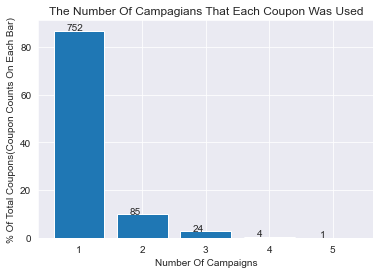

In [410]:
coupon_freq ={}
total_no_unique_coupons = len(train.coupon_id.unique())
#coupon_freq 
#keys: the number of uses of coupons
#values:number of coupons 
for key in coupon_uses.keys():
    coupon_freq[key]= len(coupon_uses[key])/total_no_unique_coupons*100
 

print(len(coupon_freq))
plt.bar(coupon_freq.keys(),coupon_freq.values())

# Text on the top of each barplot
label = [len(x) for x in coupon_uses.values()]
x_loc = np.array([x for x in coupon_freq.keys()])-0.2
y_loc = np.array([x for x in coupon_freq.values()]) + 0.1
for i in range(5):
    plt.text(x = x_loc[i] , y = y_loc[i], s = label[i], size = 10)
plt.title('The number of campagians that each coupon was used'.title())
plt.ylabel('% of total coupons(coupon counts on each bar)'.title())
plt.xlabel('number of campaigns'.title())
plt.show()

# Model Building

In [412]:
test_id = test['id']
target = train['redemption_status']
train.drop(['id','campaign_id','start_date','end_date', 'redemption_status'], axis=1, inplace=True)
test.drop(['id','campaign_id','start_date','end_date'], axis=1, inplace=True)

In [413]:
x = pd.DataFrame(train)
y = target
col_names = ['cd_sum','coupon_discount_x', 'coupon_used_x', 'item_counts', 'no_of_customers',
       'od_sum', 'other_discount_x', 'price_sum', 'qu_sum', 'quantity_x',
       'selling_price_x', 't_counts', 'total_discount_mean',
       'total_discount_sum', 'campaign_type', 'campaign_duration',
        'family_size', 'no_of_children',
       'income_bracket', 'coupon_discount_y', 'coupon_used_y',
       'no_of_items', 'other_discount_y', 'quantity_y',
       'selling_price_y', 'cdd_sum', 'customer_id_count', 'odd_sum', 'qa_sum',
       'pprice_sum']
features = x[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
x[col_names] = features
x = np.array(x)

In [414]:
target

0        0
1        0
2        0
3        0
4        0
        ..
54853    0
54854    0
54855    0
54856    0
54857    0
Name: redemption_status, Length: 54858, dtype: int64

In [415]:
print(x)

[[ 7.25000000e+02  4.50000000e+01  7.82000000e+02 ... -9.42753029e-01
   2.42055255e-02  4.71765759e-01]
 [ 2.65000000e+02  3.34000000e+02  4.34600000e+03 ...  1.05715770e+00
  -5.82960120e-01 -1.17954371e+00]
 [ 2.81000000e+02  4.08000000e+02  4.41200000e+03 ...  4.76693401e-01
  -5.59558835e-01 -7.34119568e-01]
 ...
 [ 2.77000000e+02  1.03000000e+02  4.40900000e+03 ... -4.82269085e-01
   3.48968632e+00  1.20736929e+00]
 [ 9.16000000e+02  1.84000000e+02  1.13400000e+03 ...  8.98940777e-01
   1.94735629e-01 -7.46216039e-01]
 [ 7.14000000e+02  1.33900000e+03  7.71000000e+02 ...  2.96634078e-01
   6.99234895e-01 -2.59091938e-01]]


In [416]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

In [417]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((38400, 41), (38400,), (16458, 41), (16458,))

## 1. Logistic Regression 

In [453]:
LR = LogisticRegression()
LR.fit(x_train,y_train)
y_pred_LR = LR.predict(x_test)
print(len(x_test[0]))
#print(classification_report(y_test,y_pred_LR))

41


In [419]:
roc_auc_score(y_test,y_pred_LR)
Model = ['Logistic Regression']
ROC_AUC_Accuracy = [roc_auc_score(y_test,y_pred_LR)]

#print(ROC_AUC_Accuracy)

In [420]:

results=confusion_matrix(y_test,y_pred_LR)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test,y_pred_LR) )
print ('Report : ')
print (classification_report(y_test,y_pred_LR) )

Confusion Matrix :
[[16304     8]
 [  142     4]]
Accuracy Score : 0.990885891359825
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     16312
           1       0.33      0.03      0.05       146

    accuracy                           0.99     16458
   macro avg       0.66      0.51      0.52     16458
weighted avg       0.99      0.99      0.99     16458



Get predicted probabilites

In [421]:
target_probailities_log = LR.predict_proba(x_test)[:,1]

In [422]:
#Create true and false positive rates
log_false_positive_rate,log_true_positive_rate,log_threshold = roc_curve(y_test,target_probailities_log)

Plotting the ROC curve

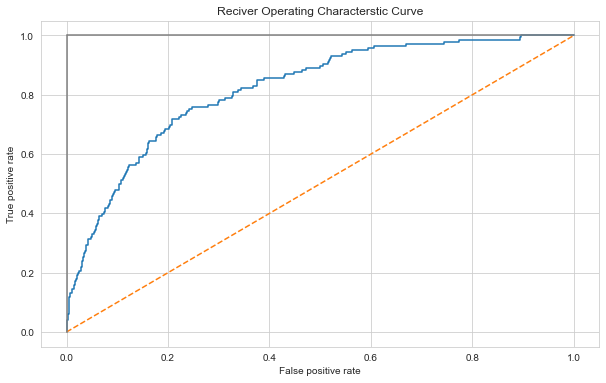

In [423]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(log_false_positive_rate,log_true_positive_rate)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## Decision Tree 

In [424]:
params = {
    
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':range(1,10),
    'max_leaf_nodes':range(2,10,1),
    'max_features':['auto','log2']
    
}

dt = DecisionTreeClassifier()

rs = RandomizedSearchCV(estimator=dt,n_jobs=-1,cv=3,param_distributions=params,scoring='recall')
rs.fit(x,y)

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 10),
                                        'max_features': ['auto', 'log2'],
                                        'max_leaf_nodes': range(2, 10),
                                        'splitter': ['best', 'random']},
                   scoring='recall')

In [425]:
dt = DecisionTreeClassifier(**rs.best_params_)
dt.fit(x_train,y_train)
y_pred_dt = dt.predict(x_test)
print(roc_auc_score(y_test,y_pred_dt))
Model.append('Decision Tree')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_dt))

0.5


In [426]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     16312
           1       0.00      0.00      0.00       146

    accuracy                           0.99     16458
   macro avg       0.50      0.50      0.50     16458
weighted avg       0.98      0.99      0.99     16458



In [427]:
Model,ROC_AUC_Accuracy

(['Logistic Regression', 'Decision Tree'], [0.5134534118927491, 0.5])

In [428]:
results=confusion_matrix(y_test,y_pred_dt)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test,y_pred_dt) )
print ('Report : ')
print (classification_report(y_test,y_pred_dt) )

Confusion Matrix :
[[16312     0]
 [  146     0]]
Accuracy Score : 0.9911289342568963
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     16312
           1       0.00      0.00      0.00       146

    accuracy                           0.99     16458
   macro avg       0.50      0.50      0.50     16458
weighted avg       0.98      0.99      0.99     16458



In [429]:
#Get predicted probabilites
target_probailities_log = dt.predict_proba(x_test)[:,1]

In [430]:
#Create true and false positive rates
log_false_positive_rate,log_true_positive_rate,log_threshold = roc_curve(y_test,target_probailities_log)

Plotting the ROC curve

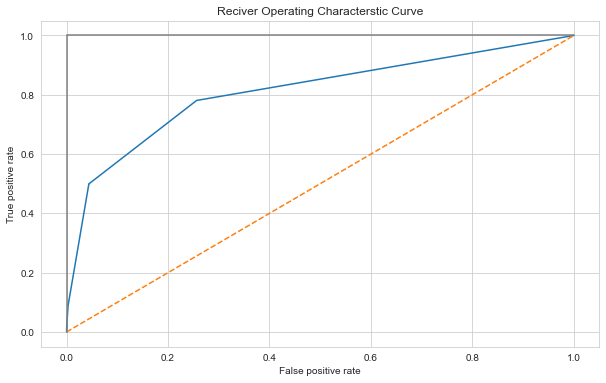

In [431]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(log_false_positive_rate,log_true_positive_rate)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

## Random Forest

In [432]:
params = {
    
    'n_estimators':range(10,100,10),
    'criterion':['gini','entropy'],
    'max_depth':range(2,10,1),
    'max_leaf_nodes':range(2,10,1),
    'max_features':['auto','log2']
    
}
rf = RandomForestClassifier()

rs = RandomizedSearchCV(estimator=rf,param_distributions=params,cv=5,scoring='recall',n_jobs=-1)
rs.fit(x,y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 10),
                                        'max_features': ['auto', 'log2'],
                                        'max_leaf_nodes': range(2, 10),
                                        'n_estimators': range(10, 100, 10)},
                   scoring='recall')

In [433]:
rf = RandomForestClassifier(**rs.best_params_)
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
print(roc_auc_score(y_test,y_pred_rf))
Model.append('Random Forest')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_rf))

0.5


In [434]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     16312
           1       0.00      0.00      0.00       146

    accuracy                           0.99     16458
   macro avg       0.50      0.50      0.50     16458
weighted avg       0.98      0.99      0.99     16458



In [435]:
results=confusion_matrix(y_test,y_pred_rf)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test,y_pred_rf) )
print ('Report : ')
print (classification_report(y_test,y_pred_rf) )

Confusion Matrix :
[[16312     0]
 [  146     0]]
Accuracy Score : 0.9911289342568963
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     16312
           1       0.00      0.00      0.00       146

    accuracy                           0.99     16458
   macro avg       0.50      0.50      0.50     16458
weighted avg       0.98      0.99      0.99     16458



In [436]:
#Get predicted probabilites
target_probailities_log = rf.predict_proba(x_test)[:,1]

In [437]:
#Create true and false positive rates
log_false_positive_rate,log_true_positive_rate,log_threshold = roc_curve(y_test,target_probailities_log)

Plotting the ROC curve

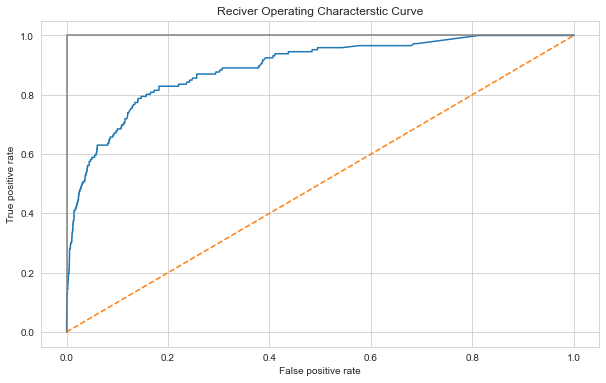

In [438]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(log_false_positive_rate,log_true_positive_rate)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [439]:
print('Model', 'Accuracy')

print('  ')

for i in range(len(Model)):
    
    print(Model[i],'---',ROC_AUC_Accuracy[i] )

Model Accuracy
  
Logistic Regression --- 0.5134534118927491
Decision Tree --- 0.5
Random Forest --- 0.5


## Saving the model to a pickle file 

In [443]:
import pickle

In [479]:
with open('model_pickle_logestic_reg','wb') as file:
    pickle.dump(LR,file)

In [480]:
with open('model_pickle_logestic_reg','rb') as file:
    lr_file = pickle.load(file)

In [481]:
lr_file.coef_

array([[ 2.19012532e-03, -2.57507214e-04, -8.27172101e-04,
        -1.30902769e-01, -4.35245278e-01, -8.15736875e-02,
        -2.88228786e-02,  6.93413713e-02,  4.27092019e-02,
         8.67483159e-02, -1.43221259e-02, -6.01402283e-02,
         3.33696612e-02,  1.29225236e-02, -2.62523902e-02,
         5.13351330e-02,  1.64002092e-02, -6.34398745e-02,
        -1.65543788e-02, -1.20993362e-01,  2.54017343e-02,
        -2.79498395e-01,  2.04060473e-02, -6.00093068e-03,
        -1.09811229e-01, -6.56971744e-02,  3.90875275e-02,
        -2.07380314e-01,  1.97182258e-01, -1.74416136e-02,
        -1.25983438e-01, -2.40870129e-02, -2.35004065e-01,
        -7.34973340e-02,  6.87359558e-02, -1.94853404e-03,
        -1.41428655e-01,  1.62220839e-02, -6.67045336e-02,
         4.57337623e-02,  3.47550038e-02]])

In [465]:
lr_file.intercept_

array([-0.11619361])

In [488]:
with open('model_pickle_random_rf','wb') as file:
    pickle.dump(rf,file)

In [489]:
with open('model_pickle_random_rf','rb') as file:
    rf_file = pickle.load(file)